In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from awesome.run.functions import *

In [ ]:
img_dir="lochblech2.jpg"
img_pil=Image.open(img_dir)
width, height = img_pil.size 
newsize = (int(width/1), int(height/1))
img_pil = img_pil.resize(newsize)

img= np.array(img_pil, dtype='float')/255.0
img = img[:,:,0:3]
nx,ny,nc = img.shape
#img = img+0.02*np.random.randn(nx,ny,nc)

In [ ]:
likelihood = img[:,:,0]
likelihood = torch.from_numpy(likelihood<0.5).float()

img_dir = "original/mask_naive.png"
likelihood= 1 - np.array(Image.open(img_dir)) / 255.
likelihood = torch.from_numpy(likelihood<0.5).float()

plt.imshow(likelihood)
plt.colorbar()
plt.show()

In [ ]:
PI  = torch.tensor(np.pi)
class myNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        
        # define network layers
        self.offset = torch.nn.Parameter(torch.zeros(1,2))
        self.offset.requires_grad = False
        self.W0 = nn.Linear(2, 2)
        self.W1 = nn.Linear(2, n_hidden)
        self.W2 = nn.Linear(n_hidden, 1)
        #self.W2.weight.data = torch.eye(2)
        
        
    def forward(self, x):
        # define forward pass
        

        x_inp = x+self.offset
        
        x = 10*3.141592*(self.W1(x_inp))
        #print(x.shape)
        #print(self.W2(F.gelu(self.W1(x_inp))).shape)
        out = self.W2(torch.sin(x))
        #out = out[:,None] +self.W2(F.relu(self.W1(x_inp)))
       
        return out

In [ ]:
torch.manual_seed(1)
def extractInformationFromLikelihood(likelihood, mask):
    indices = torch.nonzero(mask)
    N_fore = indices.shape[0]
    print(N_fore)
    pixel_info = torch.zeros((N_fore,2)) # store x,y values of all pixels the user marked as foreground

    labels = torch.zeros(N_fore)
    pixel_info[:,0] = indices[:,0] / nx -0.5
    pixel_info[:,1] = indices[:,1] / ny -0.5
    labels = likelihood[mask]
    return pixel_info, labels

net = myNet(200)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)  

num_epochs = 10000
pix_back,labels_back = extractInformationFromLikelihood(likelihood,  likelihood<0.5)
pix_fore,labels_fore = extractInformationFromLikelihood(likelihood, likelihood>0.5)

number = 500

# Train the model
for epoch in range(num_epochs):
    perm = torch.randperm(pix_back.size(0))
    idx = perm[:number]
    random_pix_back = pix_back[idx,:]
    pix_back_labels = labels_back[idx]
    
    perm = torch.randperm(pix_fore.size(0))
    idx = perm[:number]
    random_pix_fore = pix_fore[idx,:]
    pix_fore_labels = labels_fore[idx]
    
    
    outputs_back = torch.sigmoid(net(random_pix_back)).squeeze()
    outputs_fore = torch.sigmoid(net(random_pix_fore)).squeeze()
    
    loss = 2*criterion(outputs_back, pix_back_labels) + 1*criterion(outputs_fore, pix_fore_labels)
    #if epoch >100:
    #    loss += 0.1*torch.sum(torch.sigmoid(net(-net.offset.data)))
    
    #print(torch.sigmoid(net(net.offset.data)))
    #if epoch > 3000:
    #    net.offset.requires_grad = True
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (epoch+1) % 400 == 0:
        print ('Epoch [{}/{}],  Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))


In [ ]:
allPixels,temp = extractInformationFromLikelihood(likelihood,  likelihood>-0.5)

inferenceResult = net(allPixels) # torch tensor of size nx*ny
inferenceResult = inferenceResult.detach().numpy().reshape((nx,ny))

im = Image.fromarray(255*(likelihood.numpy()>0.5).astype('uint8'))
im.save("mask_naive.png")

#plt.imshow(inferenceResult)
plt.imshow(img)
plt.contour(inferenceResult, levels=[-5.0], colors='purple',linewidths=3,linestyles='solid' )
#plt.contour(inferenceResult, levels=[2.5])
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
#plt.plot((-net.offset.data.detach().numpy()[0,1]+0.5)*ny, (-net.offset.data.detach().numpy()[0,0]+0.5)*nx,'x')
#plt.colorbar()
plt.axis('off')
plt.savefig('repeating.png',bbox_inches='tight')
plt.show()
print(net.offset.data.detach().numpy())


In [ ]:
#plt.imshow(inferenceResult)
plt.imshow(img)
#plt.contour(inferenceResult, levels=[-5.0,-0.0])
plt.contour(likelihood, levels=[0.5], colors='purple',linewidths=3,linestyles='solid' )
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
#plt.plot((-net.offset.data.detach().numpy()[0,1]+0.5)*ny, (-net.offset.data.detach().numpy()[0,0]+0.5)*nx,'x')
#plt.colorbar()
plt.axis('off')
plt.savefig('result_naive.png',bbox_inches='tight')
plt.show()
print(net.offset.data.detach().numpy())


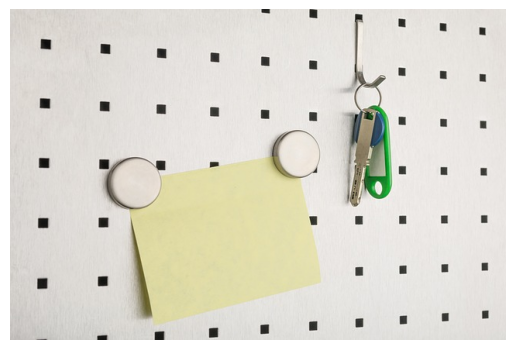

In [15]:
#plt.imshow(inferenceResult)
img = Image.open("lochblech2.jpg")
plt.imshow(img)
plt.axis('off')
plt.savefig('img.png',bbox_inches='tight')
plt.show()

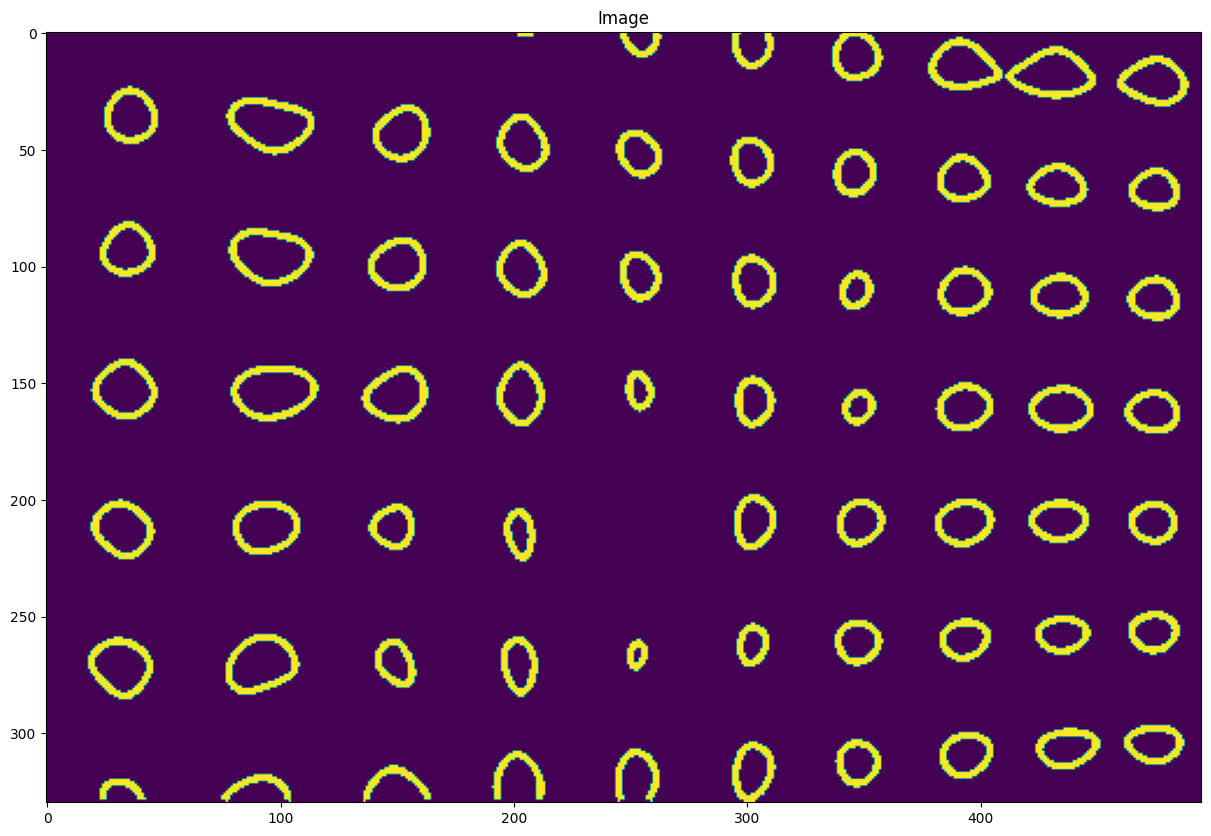

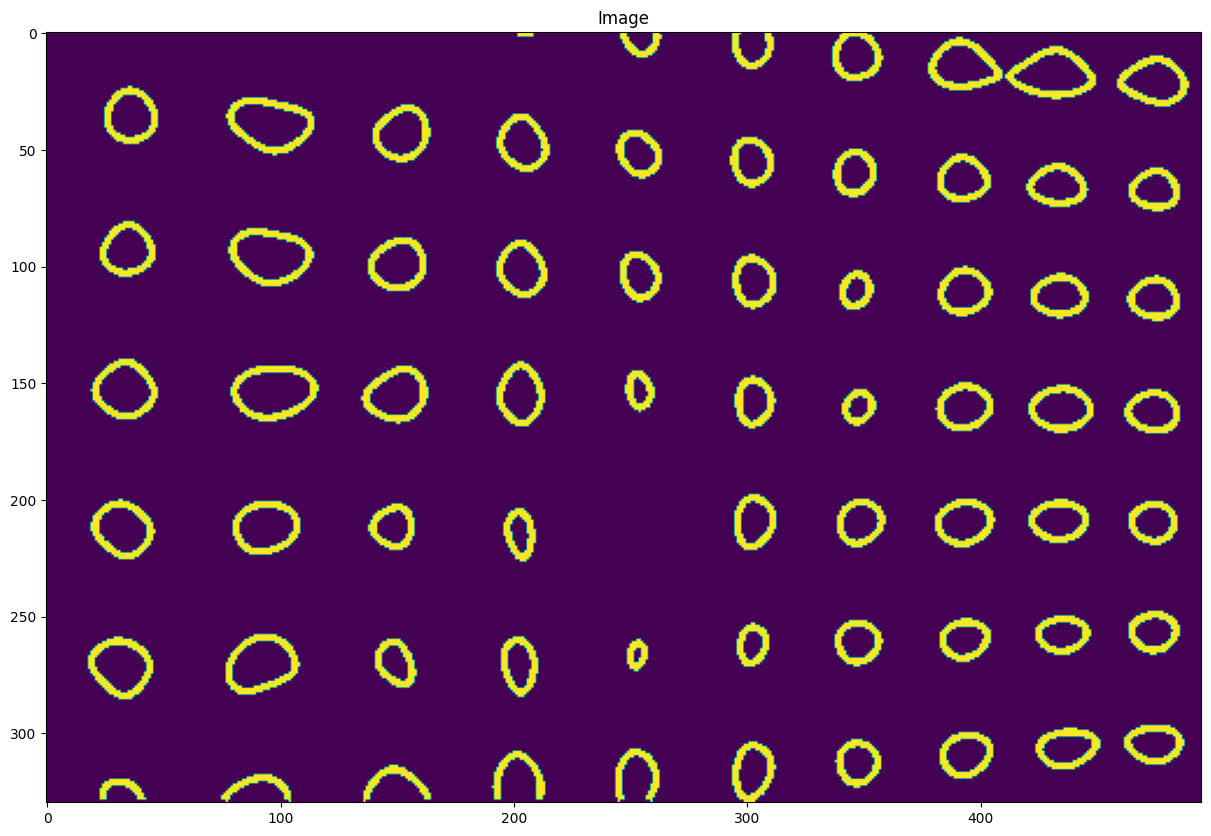

In [2]:
img_path = "original/repeating.png"
img_pil = Image.open(img_path)
img = np.array(img_pil, dtype='float')/255.0

# Remote 10 px border
img = img[10:-10,10:-10,:]
nx,ny,nc = img.shape

cond = (img[..., 0] > (120 / 255)) & (img[..., 2] > (120 / 255)) & (img[..., 1] < (10 / 255))

plot_as_image(cond, size=15)


In [3]:
import cv2
import timeit

s = timeit.default_timer()
thinned = cv2.ximgproc.thinning((cond * 255).astype(np.uint8), thinningType = cv2.ximgproc.THINNING_ZHANGSUEN)
e = timeit.default_timer()
print(e-s)
cv2.imwrite("thinned1.png", thinned)

0.00599130000000514


True

In [28]:
size = 640 / 495

cv2.imwrite("cond.png", (cond.astype(float) * 255).astype(np.uint8))


True

In [32]:
def resize_img(path, target_px, target_py):
    img = Image.open(path)
    img = img.resize((target_px, target_py))
    img.save(path)

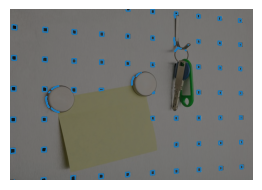

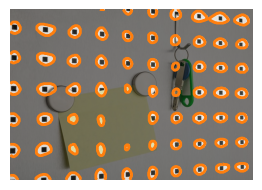

In [47]:

mask_path = './mask.png'
orig_mask = load_mask_single_channel(mask_path) / 255


mask_path_naive = './original/mask_naive.png'
likelihood = load_mask_single_channel(mask_path_naive) / 255

crop_y = slice(0, img.shape[0])
crop_x = slice(0, img.shape[1])

constraint_name = "repeating"
image_name = "board"
path = "./new/"
target_px = 1024
target_py = 768
actual_px = (crop_x.stop - crop_x.start)
actual_py = (crop_y.stop - crop_y.start)
# Recalculate crop start to get same aspect ratio as target_px and target_py
aspect = target_px / target_py
new_start = int(max(crop_x.start + ((actual_px - actual_py * aspect) / 2), 0))
crop_x = slice(int(new_start), int(actual_px * aspect + new_start))
actual_px = (crop_x.stop - crop_x.start)

naive = likelihood[crop_y, crop_x]
constraint = orig_mask[crop_y, crop_x]
pimg = img[crop_y, crop_x]
size = target_px / actual_px

darkening = 0.5

color = plt.get_cmap('tab10')(0)
save_path = path + f"{image_name}_{constraint_name}_naive.png"
plot_mask(pimg, naive, contour_linewidths=1, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True, darkening_background=darkening)
resize_img(save_path, target_px, target_py)

color = plt.get_cmap('tab10')(1)
save_path = path + f"{image_name}_{constraint_name}.png"
plot_mask(pimg, constraint, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True, darkening_background=darkening)
resize_img(save_path, target_px, target_py)

In [41]:
likelihood.shape

(427, 640)

In [33]:
resize_img("./mask.png", 640, 427)

In [ ]:
print(criterion(torch.sigmoid(net(net.offset.data)),torch.tensor(1.0)))

In [ ]:
print(torch.sigmoid(net(net.offset.data)))